In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
import shutil

def copy_and_overwrite(from_path, to_path):
    if os.path.exists(to_path):
        shutil.rmtree(to_path)
    shutil.copytree(from_path, to_path)
if iskaggle:
    copy_and_overwrite('/kaggle/input/receipts', '/kaggle/working/receipts')

In [3]:
if iskaggle:
    !pip install -Uqq fastbook

In [4]:
%%script echo skipping
from fastbook import search_images_ddg
def search_images(term, max_images=20):
    return search_images_ddg(term, max_images);
urls = search_images('store receipt photos', 10)
urls[1]

skipping


In [5]:
from fastai.vision.all import Path
receipts_path = Path('./receipts')
if iskaggle:
    receipts_path = Path('/kaggle/working/receipts/')
Path.BASE_PATH = receipts_path
receipts_path.ls()

/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(#6) [Path('labels'),Path('receipt.jpg'),Path('images_done'),Path('.ipynb_checkpoints'),Path('via.json'),Path('images')]

In [6]:
%%script echo skipping
from fastdownload import download_url
dest = (receipts_path / 'receipt.jpg')
download_url(urls[1], dest, show_progress=False)

skipping


In [7]:
from fastai.vision.all import Image, matplotlib

In [8]:
%%script echo skipping
matplotlib.rc('image', cmap='Greys')
img = Image.open(dest)

skipping


In [9]:
%%script echo skipping
img

skipping


In [10]:
%%script echo skipping
# https://github.com/JaidedAI/EasyOCR
import easyocr
import matplotlib.pyplot as plt

reader = easyocr.Reader(['en'])

# run OCR
results = reader.readtext(img)

# show the image and plot the results
plt.imshow(img)
for res in results:
    # bbox coordinates of the detected text
    xy = res[0]
    xy1, xy2, xy3, xy4 = xy[0], xy[1], xy[2], xy[3]
    # text results and confidence of detection
    det, conf = res[1], res[2]
    # show time :)
    plt.plot([xy1[0], xy2[0], xy3[0], xy4[0], xy1[0]], [xy1[1], xy2[1], xy3[1], xy4[1], xy1[1]], 'r-')
    plt.text(xy1[0], xy1[1], f'{det} [{round(conf, 2)}]')

skipping


In [11]:
%%script echo skipping
for res in results[10:20]:
    # text results and confidence of detection
    det, conf = res[1], res[2]
    print(f'txt: {det}, conf: {conf:.2f}')

skipping


In [12]:
from fastai.vision.all import download_images
path = Path.BASE_PATH
dest = (path / 'images')
dest.mkdir(exist_ok=True, parents=True)

In [13]:
%%script echo skipping
download_images(dest, urls=search_images(f'store receipt photo', 100))

skipping


In [14]:
%%script echo skipping
from fastai.vision.all import verify_images, get_image_files

failed = verify_images(get_image_files(dest))
failed.map(Path.unlink)
len(failed)

skipping


In [15]:
%%script echo skipping
it = 0
image_files = get_image_files(dest)

# Loop through each file and rename it
for x in image_files:
    new_name = (Path.BASE_PATH / 'images') / ('receipt_'  + str(it) + x.suffix)
    not renaming every time
    x.rename(new_name)
    it += 1

skipping


In [16]:
import os
import json
from PIL import Image, ImageDraw
import shutil

def create_labels(via_json, image_dir, image_done_dir, labels_dir, class_names, min_height=512, min_width=100):
    '''
    Processes a VIA JSON file and generates mask images and codes.txt.

    Args:
        via_json (str): Path to the VIA JSON file.
        image_dir (str): Directory containing the receipt images.
        image_done_dir (dir): Directory containing the images listed in JSON.
        labels_dir (str): Output directory for the mask images.
        class_names (list): List of class names corresponding to region labels.
        min_height (int): Minimum height of the cropped images.
        min_width (int): Minimum width of the cropped images.
    '''
    with open(via_json, 'r') as f:
        data = json.load(f)

    # Ensure labels and done directories exist
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(image_done_dir, exist_ok=True)
    
    # Process each image in the VIA JSON
    for image_id in data['_via_image_id_list']:
        # Extract image filename and data
        filename = data['_via_img_metadata'][image_id]['filename']
        image_data = data['_via_img_metadata'][image_id]['regions']

        # Open the image
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path).convert('L')
        img_width, img_height = img.size

        # Calculate bounding box for all regions
        min_x, min_y = float('inf'), float('inf')
        max_x, max_y = float('-inf'), float('-inf')
        
        for region in image_data:
            if region['shape_attributes']['name'] == 'rect':
                x = region['shape_attributes']['x']
                y = region['shape_attributes']['y']
                width = region['shape_attributes']['width']
                height = region['shape_attributes']['height']
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x + width)
                max_y = max(max_y, y + height)
            else:
                all_points_x = region['shape_attributes']['all_points_x']
                all_points_y = region['shape_attributes']['all_points_y']
                min_x = min(min_x, min(all_points_x))
                min_y = min(min_y, min(all_points_y))
                max_x = max(max_x, max(all_points_x))
                max_y = max(max_y, max(all_points_y))

        # Adjust the bounding box to meet minimum dimensions
        current_height = max_y - min_y
        current_width = max_x - min_x
        
        if current_height < min_height:
            extra_height = (min_height - current_height) / 2
            min_y = max(0, min_y - extra_height)
            max_y = min(max_y + extra_height, img_height)  # Ensure within image bounds
        
        if current_width < min_width:
            extra_width = (min_width - current_width) / 2
            min_x = max(0, min_x - extra_width)
            max_x = min(max_x + extra_width, img_width)  # Ensure within image bounds

        # Open the image and crop to the adjusted bounding box
        cropped_img = img.crop((min_x, min_y, max_x, max_y))

        # Create a mask image with the same size as the cropped image
        width, height = cropped_img.size
        mask_img = Image.new('L', (width, height), 0)

        # Loop through regions and fill corresponding areas in the mask
        for region in image_data:
            class_name = region['region_attributes']['name']
            class_index = class_names.index(class_name)

            if region['shape_attributes']['name'] == 'rect':
                x = region['shape_attributes']['x'] - min_x
                y = region['shape_attributes']['y'] - min_y
                width = region['shape_attributes']['width']
                height = region['shape_attributes']['height']
                mask_img.paste(class_index, (int(x), int(y), int(x + width), int(y + height)))
            else:
                all_points_x = [x - min_x for x in region['shape_attributes']['all_points_x']]
                all_points_y = [y - min_y for y in region['shape_attributes']['all_points_y']]
                polygon = [(x, y) for x, y in zip(all_points_x, all_points_y)]
                ImageDraw.Draw(mask_img).polygon(xy=polygon, fill=class_index)

        # Save the cropped image and mask
        cropped_img.save(os.path.join(image_done_dir, filename))
        mask_filename = os.path.splitext(filename)[0] + '_P.png'
        mask_img.save(os.path.join(labels_dir, mask_filename))

    # Write class names to codes.txt
    with open(os.path.join(labels_dir, 'codes.txt'), 'w') as f:
        for class_name in class_names:
            f.write(class_name + '\n')

In [17]:
via_json_path = Path.BASE_PATH / 'via.json'
image_dir = Path.BASE_PATH / 'images'
images_done_dir = Path.BASE_PATH / 'images_done'
labels_dir = Path.BASE_PATH / 'labels'
class_names = ['Void', 'total', 'date']  # Modify with your class names

create_labels(via_json_path, image_dir, images_done_dir, labels_dir, class_names)

/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
%%script echo skipping
import re

# imgs=[Image.open(o).to_thumb(256) for o in images_done_dir.ls() if int(re.compile(r'.*receipt_(\d+)\..*$').match(o.absolute().as_posix()).group(1)) % 2]
# from IPython.display import display
# for i in imgs:
#     display(i)

import matplotlib.pyplot as plt
import math

# Assuming images_done_dir.ls() is a list of image paths
image_paths = [o for o in images_done_dir.ls() if int(re.compile(r'.*receipt_(\d+)\..*$').match(o.absolute().as_posix()).group(1)) % 2]

# Calculate number of rows needed
num_images = len(image_paths)
num_cols = 3
num_rows = math.ceil(num_images / num_cols)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, path in zip(axes, image_paths):
    img = Image.open(path)
    img.thumbnail((512, 512))  # Resize image to thumbnail size
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Hide any remaining empty subplots
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

skipping


In [20]:
from fastbook import (setup_book, 
    untar_data, 
    URLs, 
    SegmentationDataLoaders, 
    get_image_files,
    np,
    unet_learner,
    resnet34,
    resnet18,
    SegmentationInterpretation)
setup_book()
path = Path.BASE_PATH

In [21]:
%%script echo skipping
from fastai.vision.all import Image
image = Image.open((path / 'images_done').ls().sorted()[0])
image

skipping


In [22]:
%%script echo skipping
label = Image.open((path / 'labels').ls().sorted()[1])
label

skipping


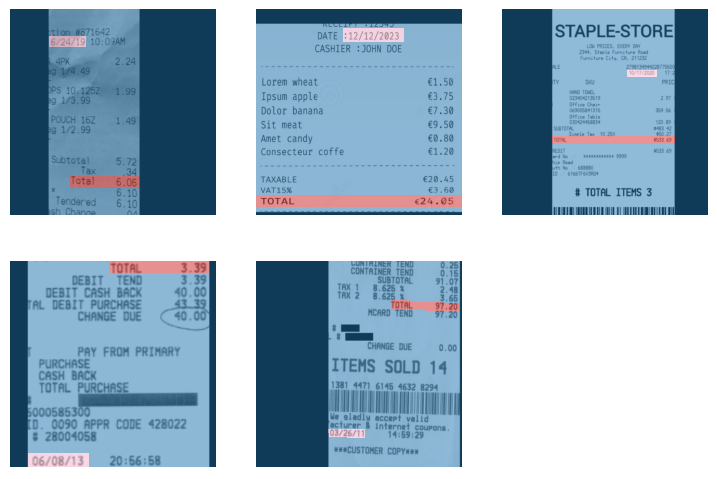

In [24]:
from fastai.vision.all import Resize, aug_transforms, Normalize, imagenet_stats
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/'images_done'),
    label_func = lambda o: path/'labels'/f'{o.stem}_P.png',
    codes = np.loadtxt(path/'labels/codes.txt', dtype=str),
    item_tfms=[Resize(512, method='pad', pad_mode='zeros')],
    # batch_tfms=[*aug_transforms(size=512), Normalize.from_stats(*imagenet_stats)],
)
dls.show_batch(max_n=5)

In [25]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time


/home/mark/miniconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


KeyboardInterrupt: 

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))